# GPT-3 Fine-tuning


## GPT-3

GPT-3 is a state-of-the-art language model developed by OpenAI, capable of generating natural language text that is virtually indistinguishable from text written by humans. GPT-3 stands for "Generative Pre-trained Transformer 3," and it is the third generation of the GPT series of language models.


## What does fine-tuning a GPT-3 model mean?

OpenAI, by default, gives you a few AI models or engines that are suited for general tasks.\
However, sometimes you don’t get the desired output, or getting the output is too expensive. \
As with any pre-trained model, GPT-3 has some limitations when it came to tackling domain-specific tasks. \
This is where fine-tuning comes into play. Fine-tuning is all about customizing that pre-trained model to fit your specific needs and make it more domain-specific. \
Fine-tuning gives you the ability to take OpenAI’s base models/engines and train a new model but on a curated dataset that you supply.

## GPT-3 Fine tuning Steps
There are three steps involved in fine-tuning GPT-3.

1. Prepare the training dataset
2. Train a new fine-tuned model
3. Use the new fine-tuned model

### Prepare training data

The training dataset has to be in jsonl format where each document is separated by a new line.

A typical dataset jsonl file looks like this.

```
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
...
```

In [4]:
import pandas as pd

df = pd.read_json('./data/hotel-q&a.json')
print(f"Before cleaning: {len(df)=}")
df.sample(5)

Before cleaning: len(df)=232


,question,answer
34,What is the hotel's concierge service?,Our concierge service can help you with variou...
59,Is there a gift shop in the hotel?,"Yes, we have a gift shop on site where you can..."
107,Do you have a pool?,"Yes, we have a pool that is open from 8:00 AM ..."
124,What hotel services do you offer?,We offer a variety of hotel services such as r...
66,Do you offer room upgrades?,"Yes, we do offer room upgrades based on availa..."


In [36]:
prompt_attr = 'question'
completion_attr = 'answer'

df = df[[prompt_attr, completion_attr]]
df.columns = ['prompt', 'completion']
df.sample(2)

,prompt,completion
193,Do you have any upcoming events or activities?,"Yes, we have a range of events and activities ..."
115,What are the benefits of your loyalty program?,Our loyalty program offers a variety of benefi...


In [38]:
df = df[df['prompt'].str.endswith('?')]
print(f"After cleaning: {len(df)=}")

After cleaning: len(df)=232


In [39]:
df['completion'] = df['completion'].apply(lambda completion: " " + completion.strip() + "\n") # add whitespace and \n for better training

Our data must be a JSONL document, where each line is a prompt-completion pair.

In [41]:
dataset_path = './data/hotel-q&a-dataset.jsonl'
df.to_json(dataset_path, orient='records', lines=True)

Data Preparation tool.

A tool which validates, gives suggestions and reformats our data:

In [42]:
!openai tools fine_tunes.prepare_data -f "./data/hotel-q&a-dataset.jsonl" -q

Analyzing...

- Your file contains 232 prompt-completion pairs
- There are 2 duplicated prompt-completion sets. These are rows: [28, 41]
- All prompts end with suffix `?`
- All prompts start with prefix `HotelBot question: `. Fine-tuning doesn't require the instruction specifying the task, or a few-shot example scenario. Most of the time you should only add the input data into the prompt, and the desired output into the completion
- All completions end with suffix `\n`

Based on the analysis we will perform the following actions:
- [Recommended] Remove 2 duplicate rows [Y/n]: Y
- [Recommended] Remove prefix `HotelBot question: ` from all prompts [Y/n]: Y


Your data will be written to a new JSONL file. Proceed [Y/n]: Y

Wrote modified file to `./data/hotel-q&a-dataset_prepared.jsonl`
Feel free to take a look!

Now use that file when fine-tuning:
> openai api fine_tunes.create -t "./data/hotel-q&a-dataset_prepared.jsonl"

After you’ve fine-tuned a model, remember that your prompt has to

D:\Files\Documents\JYU\Deep-Learning for Cognitive Computing for Developers\MiniProject\fine-tune\.venv\lib\site-packages\openai\validators.py:283: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["prompt"] = x["prompt"].str[len(prefix) :]


### Train a new fine-tuned model

In [ ]:
%env OPENAI_API_KEY=your_secret_key

The tool suggests we run the following command to train the dataset. 
```
openai api fine_tunes.create -t "./data/hotel-q&a-dataset_prepared.jsonl
```

We can simply copy the suggested command from the CLI tool. We specifically add -m davinci and --n_epochs=2 (by default it is 4)

In [ ]:
!openai api fine_tunes.create -t "./data/hotel-q&a-dataset_prepared.jsonl" -m curie --n_epochs=2

In [43]:
!openai api fine_tunes.create -t "./data/hotel-q&a-dataset_prepared.jsonl" -m davinci --n_epochs=2

Uploaded file from ./data/hotel-q&a-dataset_prepared.jsonl: file-cLffYLZbphh3hVdWDUuLBAnS


Upload progress:   0%|          | 0.00/42.9k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 42.9k/42.9k [00:00<?, ?it/s]



Created fine-tune: ft-WGvhVYGL7dj7kxndrRGm2f5r
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-05-09 18:53:58] Created fine-tune: ft-WGvhVYGL7dj7kxndrRGm2f5r

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-WGvhVYGL7dj7kxndrRGm2f5r



In [44]:
import time
import openai
import json
job_id = "ft-WGvhVYGL7dj7kxndrRGm2f5r"

while True:
    fine_tuning_status = openai.FineTune.retrieve(job_id)
    status = fine_tuning_status["status"]
    print(f"Fine-tuning job status: {status}")

    with open('./status.json', 'r') as f:
        data = json.load(f)
        data['status'].append(fine_tuning_status)

    with open('./status.json', 'w') as f:
        json.dump(data, f, indent=2)

    if status in ["completed", "failed", 'succeeded']:
        break

    time.sleep(60)

Fine-tuning job status: pending
Fine-tuning job status: pending
Fine-tuning job status: pending
Fine-tuning job status: pending
Fine-tuning job status: pending
Fine-tuning job status: running
Fine-tuning job status: running
Fine-tuning job status: running
Fine-tuning job status: running
Fine-tuning job status: running
Fine-tuning job status: running
Fine-tuning job status: succeeded


In [1]:
!openai api fine_tunes.follow -i ft-WGvhVYGL7dj7kxndrRGm2f5r

[2023-05-09 18:53:58] Created fine-tune: ft-WGvhVYGL7dj7kxndrRGm2f5r
[2023-05-09 18:56:46] Fine-tune costs $0.45
[2023-05-09 18:56:46] Fine-tune enqueued. Queue number: 2
[2023-05-09 18:57:36] Fine-tune is in the queue. Queue number: 1
[2023-05-09 18:59:54] Fine-tune is in the queue. Queue number: 0
[2023-05-09 19:00:12] Fine-tune started
[2023-05-09 19:03:59] Completed epoch 1/2
[2023-05-09 19:05:07] Completed epoch 2/2
[2023-05-09 19:05:40] Uploaded model: davinci:ft-personal-2023-05-09-16-05-39
[2023-05-09 19:05:41] Uploaded result file: file-xJiSI8uRivQhNUCwlOMXYMRQ
[2023-05-09 19:05:41] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m davinci:ft-personal-2023-05-09-16-05-39 -p <YOUR_PROMPT>


### Analyzing the fine-tuned model

In [8]:
!openai api fine_tunes.results -i ft-fHUEGrb4Fpao0IztQE6Uo09z > result_curie.csv

In [9]:
!openai api fine_tunes.results -i ft-WGvhVYGL7dj7kxndrRGm2f5r > result_davinci.csv

### Curie

In [10]:
results_curie = pd.read_csv('./result_curie.csv')
results_curie[results_curie['training_token_accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy
653,654,22950,654,0.044406,1.0,1.0


Text(0.5, 1.0, 'Training loss')

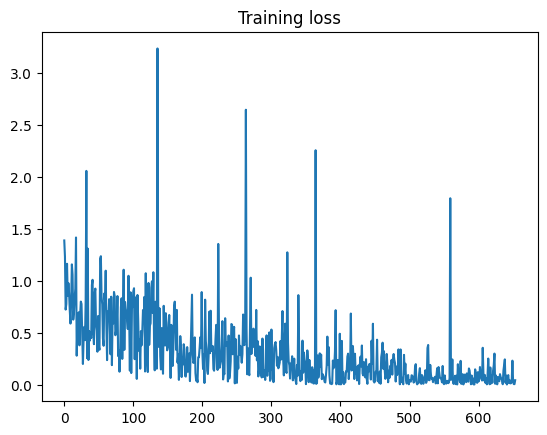

In [11]:
results_curie[results_curie['training_token_accuracy'].notnull()]['training_loss'].plot().set_title('Training loss')

Text(0.5, 1.0, 'Training token accuracy')

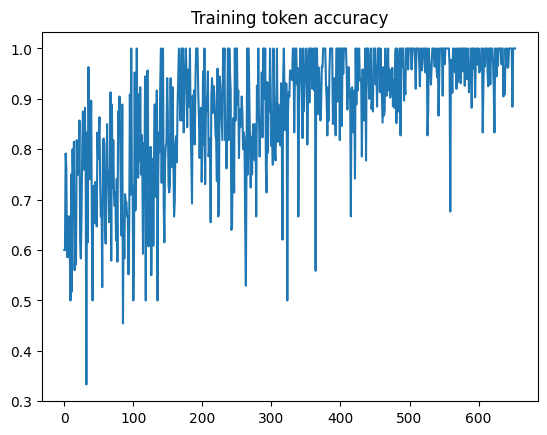

In [17]:
results_curie[results_curie['training_token_accuracy'].notnull()]['training_token_accuracy'].plot().set_title('Training token accuracy')

### Davinci

In [13]:
results_davinci = pd.read_csv('./result_davinci.csv')
results_davinci[results_davinci['training_token_accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy
461,462,16982,462,0.016711,1.0,1.0


Text(0.5, 1.0, 'Training loss')

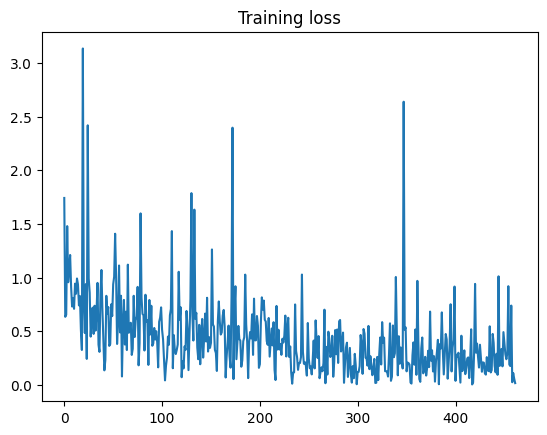

In [14]:
results_davinci[results_davinci['training_token_accuracy'].notnull()]['training_loss'].plot().set_title('Training loss')

Text(0.5, 1.0, 'Training token accuracy')

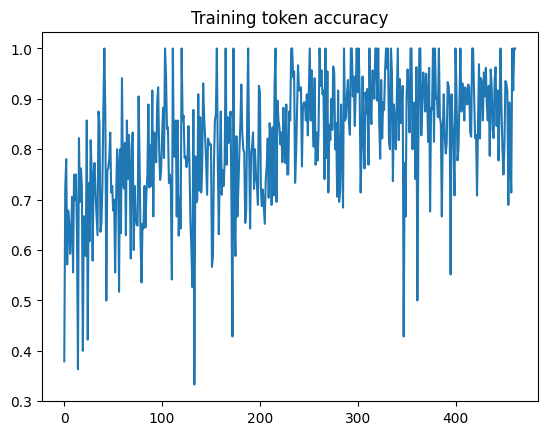

In [16]:
results_davinci[results_davinci['training_token_accuracy'].notnull()]['training_token_accuracy'].plot().set_title('Training token accuracy')

## Advanced usage

### Hyperparameters
We've picked default hyperparameters that work well across a range of use cases. The only required parameter is the training file.

That said, tweaking the hyperparameters used for fine-tuning can often lead to a model that produces higher quality output. In particular, you may want to configure the following:

* model: The name of the base model to fine-tune. You can select one of "ada", "babbage", "curie", or "davinci".
* n_epochs - defaults to 4. The number of epochs to train the model for. An epoch refers to one full cycle through the training dataset.
* batch_size - defaults to ~0.2% of the number of examples in the training set, capped at 256. The batch size is the number of training examples used to train a single forward and backward pass. In general, we've found that larger batch sizes tend to work better for larger datasets.
* learning_rate_multiplier - defaults to 0.05, 0.1, or 0.2 depending on final batch_size. The fine-tuning learning rate is the original learning rate used for pretraining multiplied by this multiplier. We recommend experimenting with values in the range 0.02 to 0.2 to see what produces the best results. Empirically, we've found that larger learning rates often perform better with larger batch sizes.
* compute_classification_metrics - defaults to False. If True, for fine-tuning for classification tasks, computes classification-specific metrics (accuracy, F-1 score, etc) on the validation set at the end of every epoch.

## Best practices

### Conditional generation
Conditional generation is a problem where the content needs to be generated given some kind of input. This includes paraphrasing, summarizing, entity extraction, product description writing given specifications, chatbots and many others. 

For this type of problem it is recommended:

* Use a separator at the end of the prompt, e.g. `\n\n###\n\n`. Remember to also append this separator when you eventually make requests to your model.
* Use an ending token at the end of the completion, e.g. `END`
* Remember to add the ending token as a stop sequence during inference, e.g. `stop=[" END"]`
* Aim for at least **~500** examples
* Ensure that the prompt + completion doesn't exceed **2048** tokens, including the separator
* Ensure the examples are of high quality and follow the same desired format
* Ensure that the dataset used for finetuning is very similar in structure and type of task as what the model will be used for
* Using Lower learning rate and only **1-2** epochs tends to work better for these use cases

## References

* https://platform.openai.com/docs/guides/fine-tuning
* https://github.com/openai/openai-cookbook/blob/main/examples/Fine-tuned_classification.ipynb
* https://medium.com/@kapildevkhatik2/mastering-gpt-3-a-comprehensive-guide-to-fine-tuning-with-openai-complete-with-examples-e28515c22d92
* https://harishgarg.com/writing/how-to-fine-tune-gpt-3-api/
* https://learn.microsoft.com/en-us/azure/cognitive-services/openai/how-to/fine-tuning?pivots=programming-language-python
* https://medium.com/version-1/my-journey-of-fine-tuning-gpt-3-with-a-custom-dataset-73666cee084e
* http://help.sentiment140.com/for-students/